In [ ]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt

# Scale 변환:평균,표준편차 기준
from sklearn.preprocessing import StandardScaler
# linkage: 계층형 군집분석, dendrogram: 계층구조 나무, cluster: linkage로부터 얻은 값으로 군집 생성
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# 군집 방법 : AgglomerativeClustering(계층형), KMeans(k-평균), DBSCAN
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

# 실루엣(Silhouette) 계수 산출
from sklearn.metrics import silhouette_samples, silhouette_score
# 실루엣 계수 산출 및 시각화 라이브러리 (pip install yellowbrick 실행)
from yellowbrick.cluster import SilhouetteVisualizer

#### 그래프 옵션 지정

In [ ]:
# 그래프 한글폰트 적용:맑은 고딕
matplotlib.rc("font", family = "Malgun Gothic")
# 그래프 (-) 기호 표시
matplotlib.rc("axes", unicode_minus = False)

### 데이터 구성하기

In [ ]:
# df_raw = pd.read_csv("D:/WORK/Data/직무능력평가.csv", engine = "python")
df_raw = pd.read_csv("D:/WORK/Data/직무능력평가.csv")
df_raw.head()

In [ ]:
# 데이터 표준화
scaler = StandardScaler()
df_raw_scaled = scaler.fit_transform(df_raw)

# 위에서부터 자료 5개 확인
df_raw_scaled[:5]

#### 데이터 분리

In [ ]:
# 목표 변수:모든 행 & 1번째 열
df_raw_y = df_raw_scaled[:, 0]
# 설명 변수::모든 행 & 1번째 제외한 모든 열
df_raw_x = df_raw_scaled[:,1::]

## @계층형 군집분석

In [ ]:
# 연결: ward, 거리 계산: Euclidean: ward~Euclidean
Z_ward = linkage(df_raw_x, method = "ward", metric = "euclidean")
# 연결: average, 거리 계산: Euclidean
Z_average = linkage(df_raw_x, method = "average", metric = "euclidean")

In [ ]:
# 군집 생성 결과 확인
Z_ward

In [ ]:
#덴드로그램[연결: ward, 거리 계산: Euclidean]
plt.figure(figsize=(10,6))
ax = plt.subplot(111) 
# DataFrame 변경:Z_ward, Z_average, Z_Minkowski
dendrogram(Z_ward, leaf_font_size=10, orientation= "top")
plt.title("군집 Dendrogram - Ward, Euclidean")
plt.xlabel("# of Data")
plt.ylabel("Distance")

In [ ]:
#덴드로그램[연결: average, 거리 계산: Euclidean]
plt.figure(figsize=(10,6))
ax = plt.subplot(111) 
dendrogram(Z_average, leaf_font_size=10, orientation= "top")
plt.title("군집 Dendrogram - Average, Euclidean")
plt.xlabel("# of Data")
plt.ylabel("Distance")

In [ ]:
# linkage 함수를 통해 얻은 Z_ward 행렬 데이터를 이용하여 군집 생성
cluster_H = fcluster(Z = Z_ward, t = 5, criterion="distance")
# 데이터에 계층형 군집 결과 입력
df_raw["cluster_H"] = cluster_H
df_raw.head()

In [ ]:
# 집계 함수를 이용한 군집별 데이터 요약
df_summary_H = df_raw.groupby("cluster_H").agg(["min", "mean", "max"])
# 집계 함수를 이용할 경우 열 이름이 두 줄에 걸쳐 나오므로 한 줄로 변환
level0 = df_summary_H.columns.get_level_values(0)
level1 = df_summary_H.columns.get_level_values(1)
df_summary_H.columns = level0 + "_" + level1
df_summary_H.reset_index(inplace = True)
df_summary_H.round(3)

In [ ]:
# Boxplot을 활용한 군집별 설명변수 분포
df_raw.boxplot(column=["DISSATIS", "PRIVILEGE","CHANCE", "ADVANCE", "CRITISM", "PROMOTION"]
               , by = "cluster_H")

In [ ]:
# Boxplot을 활용한 군집별 변수 분포
df_raw.boxplot(column=["DISSATIS", "PRIVILEGE","CHANCE", "ADVANCE", "CRITISM", "PROMOTION"]
               , by = "cluster_H")

In [ ]:
# Boxplot을 활용한 군집별 목표변수 분포
df_raw.boxplot(column=["EVAL"], by = "cluster_H", figsize=(4,3))

## @k-평균 군집분석

In [ ]:
# 최대 군집 생성 개수
n_iter_cluster = 15
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range:
    clus = KMeans(v_n_clus)
    clus.fit(df_raw_x)
    
    # 각 데이터로부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
df_error = pd.DataFrame({"NumberofCluster": cluster_range, "Error": clus_error})
df_error.round(3)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_error["NumberofCluster"], df_error["Error"])
plt.title("Clusters vs. Sum of Square")
plt.xlabel("# of Clusters")
plt.ylabel("Sum of Square")

In [ ]:
clus = KMeans(5)
clus.fit(df_raw_x)
cluster_KM = [i+1 for i in clus.labels_]
df_raw["cluster_KM"] = cluster_KM
df_raw.head(10)

In [ ]:
df_summary_KM = df_raw.drop("cluster_H", axis = 1, inplace=False). \
    groupby("cluster_KM").agg(["min", "mean", "max"])
level0 = df_summary_KM.columns.get_level_values(0)
level1 = df_summary_KM.columns.get_level_values(1)
df_summary_KM.columns = level0 + "_" + level1
df_summary_KM.reset_index(inplace = True)
df_summary_KM.round(3)

In [ ]:
# Boxplot을 활용한 군집별 tjfaud변수 분포
df_raw.boxplot(column=["DISSATIS", "PRIVILEGE","CHANCE", "ADVANCE", "CRITISM", "PROMOTION"]
               , by = "cluster_KM")

In [ ]:
# Boxplot을 활용한 군집별 목표변수 분포
df_raw.boxplot(column=["EVAL"], by = "cluster_KM", figsize=(4,3))

## 적정 군집 수 결정

### @예제-적정 군집 수 결정
. sklearn에서 지원하는 AgglomerativeClustering, KMeans (실루엣 계수는 silhouette_score 활용)

In [ ]:
# scipy.cluster.hierarchy의 계층형 군집분석은 실루엣 계수 산출 안됨
# 실루엣 계수 산출:sklearn.AgglomerativeClustering(계층형군집분석)
cls_h = AgglomerativeClustering(n_clusters=3).fit_predict(df_raw_x)  # 군집 수 =3
sil_score = silhouette_score(df_raw_x, cls_h, metric='euclidean')
print( "계층형(군집 수=3) 실루엣 계수 = ",format(round(sil_score,3)))

cls_h = AgglomerativeClustering(n_clusters=4).fit_predict(df_raw_x)  # 군집 수 =4
sil_score = silhouette_score(df_raw_x, cls_h, metric='euclidean')
print( "계층형(군집 수=4) 실루엣 계수 = ",format(round(sil_score,3)))

In [ ]:
# 실루엣 계수 산출:sklearn.KMeans(k평균군집분석)
cls_k = KMeans(3).fit_predict(df_raw_x)  # 군집 수 =3
sil_score = silhouette_score(df_raw_x, cls_k)
print( "k-평균(군집 수=3) 실루엣 계수 = ",format(round(sil_score,3)))

cls_k = KMeans(4).fit_predict(df_raw_x)  # 군집 수 =4
sil_score = silhouette_score(df_raw_x, cls_k)
print( "k-평균(군집 수=4) 실루엣 계수 = ",format(round(sil_score,3)))

#### @@ 해석
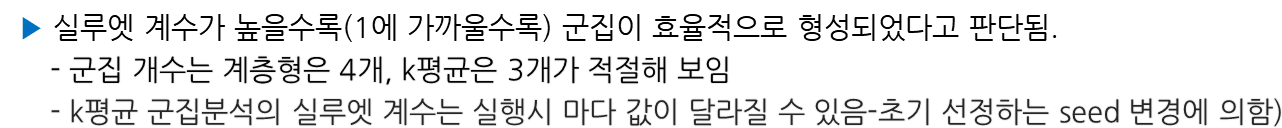

### @참조-적정 군집 수 결정
. sklearn에서 지원하는 AgglomerativeClustering (실루엣 계수는 silhouette_samples, silhouette_score 활용)

In [ ]:
f, axes = plt.subplots(1, 5, sharex=True, sharey=True)
f.set_size_inches(15, 3)

for i, ax in enumerate(axes):
#     cluster_nums = AgglomerativeClustering(n_clusters=i+2).fit_predict(df_raw_x)
    cluster_nums = KMeans(n_clusters=i+2).fit_predict(df_raw_x)
    
    sil_samples = silhouette_samples(df_raw_x, cluster_nums, metric='euclidean')
    sil_score = silhouette_score(df_raw_x, cluster_nums, metric='euclidean')
    ax.plot(sorted(sil_samples), color='red',linestyle='dashed', linewidth=2)
    ax.set_title("# of Cluster:{} , score:{}".format(round(i+2), format(round(sil_score, 2))))
plt.savefig('../sil_of_cluster.svg')
plt.show()

### @@적정 군집 수 결정
. 실루엣 계수 점수/라이브러리(yellowbrick) 활용

In [ ]:
# yellowbrick 라이브러리의 SilhouetteVisualizer 이용

clus = KMeans(3)
graph_sil = SilhouetteVisualizer(clus, colors='yellowbrick')

#생성된 visualizer에 데이터 입력 
graph_sil.fit(df_raw_x)      
graph_sil.show()
print( "실루엣 계수 = ",format(round(graph_sil.silhouette_score_,4)))

In [ ]:
clus = KMeans(4)

#visualizer 생성
graph_sil = SilhouetteVisualizer(clus, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
graph_sil.fit(df_raw_x)      
graph_sil.show()
print( "실루엣 계수 = ",format(round(graph_sil.silhouette_score_,4)))

In [ ]:
clus = KMeans(5)

#visualizer 생성
graph_sil = SilhouetteVisualizer(clus, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
graph_sil.fit(df_raw_x)      
graph_sil.show()
print( "실루엣 계수 = ",format(round(graph_sil.silhouette_score_,4)))

### @참조:DBSCAN 군집

In [ ]:
# X축: DISSATIS 변수, Y축: CHANCE
X = df_raw["DISSATIS"]
Y = df_raw["CHANCE"]
# 데이터 point 그림 종류
markers = ["o", "v", "^", "s", "<", ">", "p", "D"]
# eps: 1.0~1.5, min_sample: 2~5
para_eps = [k/10 for k in range(10, 16, 1)]
para_min_sample = [2,3,4,5]
fig, axes = plt.subplots(len(para_eps), len(para_min_sample), figsize = (15, 15)) # plot 개수
fig.tight_layout(w_pad=1, h_pad=3) # plot 간 간격
# enumerate(): 값의 index와 값을 순차적으로 반환
for i, eps in enumerate(para_eps):
    for j, min_sample in enumerate(para_min_sample):
        dbscan = DBSCAN(min_samples=min_sample, eps = eps) # dbscan 실행
        clusters = dbscan.fit_predict(df_raw_x) # 예측 분류
        clusters = clusters + 1 # noise의 경우 -1로 표기되므로 1씩 더하여 0으로 변환
        for (n_clus, clus) in enumerate(range(min(clusters), max(clusters)+1, 1)): # 군집별 다른 그림 지정
            axes[i, j].scatter(X[clusters == clus], Y[clusters == clus], marker = markers[n_clus], s = 100)
            axes[i, j].set_title("eps = " + str(eps) + ", min_sample = " + str(min_sample) +\
                                 "\n # of cluser = " + str(max(clusters)), fontsize = 15)


In [ ]:
# eps: 특정 데이터로부터 다른 데이터를 포함하는 거리 min_samples: 군집이 되기 위한 최소 데이터 수
dbscan = DBSCAN(eps=1.4, min_samples=2).fit(df_raw_x)
# 군집 결과
cluster_DB = dbscan.labels_
# sklearn의 DBSCAN에서는 noise 데이터의 경우 군집이 -1로 표시되며 0번 군집부터 시작
# 다른 계층형, K-평균은 1번 군집부터 시작하므로 다른 군집 번호와 통일. Noise 데이터는 0번 군집으로 표기
for (i, val) in enumerate(cluster_DB):
    if val < 0:
        cluster_DB[i] = 0
    else:
        cluster_DB[i] = cluster_DB[i] + 1
df_raw["cluster_DB"] = cluster_DB
df_raw.head()


In [ ]:
# DB 스캔 군집별 요약 통계량
df_summary_DB = df_raw.drop(["cluster_H", "cluster_KM"],
                                   axis = 1,
                                   inplace=False).\
                groupby("cluster_DB").agg(["min", "mean", "max"])
level0 = df_summary_DB.columns.get_level_values(0)
level1 = df_summary_DB.columns.get_level_values(1)
df_summary_DB.columns = level0 + "_" + level1
df_summary_DB.reset_index(inplace = True)
df_summary_DB.round(3)


## End of 군집분석